In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
from collections import defaultdict
from iowa_env import Iowa_Gambling_Task ## game

In [2]:
class QLearningAgent: ## Define Qlearning agent 
    def __init__(self, learning_rate, beta, gamma, get_legal_actions):
        self.get_legal_actions = get_legal_actions
        self.qvalues = defaultdict(lambda: defaultdict(lambda: 0.0)) # Ensure float values
        self.learning_rate = learning_rate
        self.gamma = gamma 
        self.beta = beta ## inverse temperature와 관련된 파라미터

    def get_qvalue(self, state, action): ## Q(state,action) return 
        return self.qvalues[state][action]

    def get_value(self, state): 
        #V(s) = max_a Q(state,action) 이용하기 
        possible_actions = self.get_legal_actions(state) ## 가능한 action 가져오기
        if not possible_actions:
            return 0.0
        # Ensure qvalues are floats for max comparison
        q_values = [] ## q_value를 보관할 리스트
        for action in possible_actions: ## 가능한 행동의 q_value들을 리스트에 삽입하기
          q_values.append(self.get_qvalue(state, action))
        value = max(q_values) ## 가장 높은 q_value 찾기
        return value

    def update(self, state, action, reward, next_state):
        # Q(s,a) += learning_rate * (r + gamma * V(s') - Q(s,a))
        gamma = self.gamma
        learning_rate = self.learning_rate
        ## V(s') 는 구현 알고리즘에 따라 달라질 수 있음. 
        new_q = self.get_qvalue(state, action)
        new_q += learning_rate*(reward+gamma*self.get_value(next_state) - self.get_qvalue(state, action))
        ## update qvalue
        self.qvalues[state][action] = new_q

    def softmax(self, q_values):
        q_values = np.array(q_values) ## q_values를 np.array로 변환
        nor_q_values = q_values-np.max(q_values) ## 확인해보기
        beta_q_values = self.beta * nor_q_values ## beta 곱하기
        exp_q_values  = np.exp(beta_q_values) ## exp
        probs = exp_q_values/np.sum(exp_q_values) ## 밑 나누기
        return probs 


    def get_action(self, state): 
    
        possible_actions = self.get_legal_actions(state) ## 가능한 행동 가져오기
        if not possible_actions:
            return None
        q_values = []
        for action in possible_actions: 
            q_values.append(self.get_qvalue(state,action))
        probs = self.softmax(q_values)
        chosen_action = np.random.choice(possible_actions, p=probs)
        return chosen_action    

In [3]:
def play_and_train(env, agent, t_max=10**2): ## 한 번의 episode를 돌리는 거임.
    """ Runs one episode, trains the agent, returns total reward. """
    total_reward = 0.0
    q_values = []
    s, info = env.reset() # 환경 초기화

    for t in range(t_max):
        a = agent.get_action(s)
        if a is None: # Handle cases where no actions are possible (shouldn't happen in these envs)
             break
        
        # Use gymnasium step signature
        next_s, r, terminated, _ = env.step(a)
        
        # Train the agent
        agent.update(s, a, r, next_s)

        q_values.append([agent.qvalues[s][0], agent.qvalues[s][1], agent.qvalues[s][2], agent.qvalues[s][3]]) ## 행동 4가지 밖에 없어서

        s = next_s
        total_reward += r
        if terminated : # Use gymnasium termination flags
            break

    return total_reward, q_values

mean reward = 2600.0


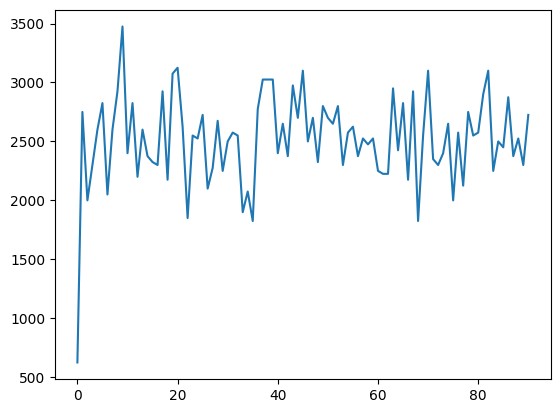

In [23]:
env = Iowa_Gambling_Task()
trials = 100
n_actions = env.action_space.n
env.reset()

## agent 정의
agent = QLearningAgent(learning_rate=0.01, beta = 1.0, gamma=0.99,
                       get_legal_actions=lambda s: range(n_actions))

rewards = []
many_trial_q_values = [] 
for i in range(trials):
    reward, q_vals = play_and_train(env, agent)
    rewards.append(reward)
    many_trial_q_values.extend(q_vals) 
    if i % 10 == 0:
        clear_output(True)
        print('mean reward =', np.mean(rewards[-10:]))
        plt.plot(rewards)
        plt.show()

(10000, 4)


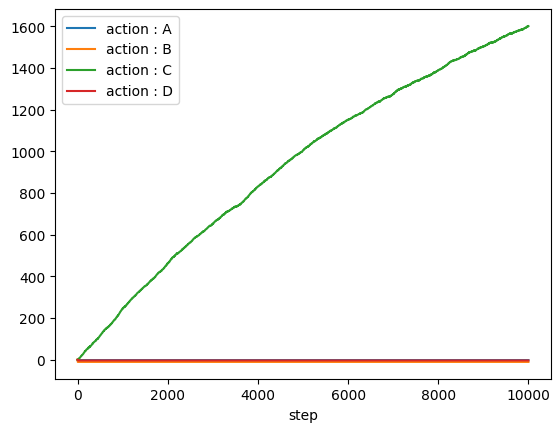

In [24]:
## 전체적인 figure
arr_q_values = np.array(many_trial_q_values)
print(arr_q_values.shape)
for action in range(4):
    plt.plot(arr_q_values[:, action], label = f"action : {chr(action+65)}")
plt.legend()
plt.xlabel("step")
plt.show()

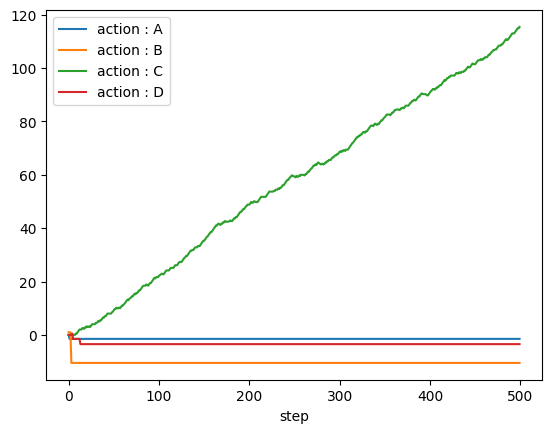

In [25]:
## 초반의 figure(5번의 trials 까지)
arr_q_values = np.array(many_trial_q_values[:500])
for action in range(4):
    plt.plot(arr_q_values[:, action], label = f"action : {chr(action+65)}")
plt.legend()
plt.xlabel("step")
plt.show()